# Clustering Notebook
###### Author: Ronaldlee Ejalu
###### DSC 478 Programming Machine Learning Apps
######  Assignment 3 Part 2

<p>For this problem you will use a different subset of the 20 Newsgroup data set that you used in Assignment 2. The subset for this assignment includes 2,500 documents (newsgroup posts), each belonging to one of 5 categories <strong> windows </strong>(0), <strong>crypt </strong>(1), <strong>christian </strong>(2), <strong>hockey </strong>(3), <strong>forsale </strong>(4). The documents are represented by 9328 terms (stems). The dictionary (vocabulary) for the data set is given in the file "terms.txt" and the full term-by-document matrix is given in "matrix.txt" (comma separated values). The actual category labels for the documents are provided in the file "classes.txt". Your goal in this assignment is to perform clustering on the documents and compare the clusters to the actual categories.

My tasks in this problem are the following [Note: for the clustering part of this assignment we should use the kMeans module form Ch. 10 of MLA (use the version provided here as it includes some corrections to the book version). We also use Pandas and other modules from scikit-learn for preprocessing or evaluation.] </p>

In [1]:
# load the necessary packages
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split 
import pylab as pl
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.metrics import completeness_score, homogeneity_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.set_option("display.precision", 4)
np.set_printoptions(precision=4)
plt.style.use('ggplot')

##### a. Create your own distance function that, instead of using Euclidean distance, uses Cosine similarity. This is the distance function we will use to pass to the kMeans function.

In [2]:
'''
k Means Clustering for Ch10 of Machine Learning in Action
@author: Peter Harrington
'''
from numpy import *

def distEuclid(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2))) #la.norm(vecA-vecB)

In [3]:
def cosineDist(vecA, vecB):
    """Function that returns cosine Similarity"""
    a_norm = np.linalg.norm(vecA)
    b_norm = np.linalg.norm(vecB)
    
    cosine = np.dot(vecA, vecB) / (a_norm * b_norm)
    dist = 1 - cosine
    
    return dist

In [4]:
def randCent(dataSet, k):
    '''
    randCent(), creates a set of k ran-dom  centroids  for  a  given  dataset.  
    The  random  centroids  need  to  be  within  thebounds of the dataset. 
    This is accomplished by finding the minimum and maximumvalues of each dimension 
    in the dataset. 
    Random values from 0 to 1.0 are then chosenand  scaled  by  the  range  and  
    minimum  value  to  ensure  that  the  random  points  arewithin  the  bounds  
    of  the  data.  
    '''
    n = shape(dataSet)[1]
    centroids = zeros((k,n), dtype=float)
    for j in range(n): #create random cluster centers
        minJ = min(dataSet[:,j])
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = minJ + rangeJ * random.rand(k)
    return centroids 

In [5]:
# kMeans function
def kMeans(dataSet, k, distMeas=distEuclid, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = zeros((m,2)) #create mat to assign data points 
                                  #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m): #for each data point assign it to the closest centroid
            minDist = inf; minIndex = -1
            for j in range(k):  #find the closest distance
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        # print centroids
        for cent in range(k):#recalculate centroids and update the centroid location
            ptsInClust = dataSet[nonzero(clusterAssment[:,0]==cent)[0]] #get all the point in this cluster - Note: this was incorrect in the original distribution.
            if(len(ptsInClust)!=0):
                centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean - Note condition was added 10/28/2013
    return centroids, clusterAssment

In [6]:
def biKmeans(dataSet, k, distMeas=distEuclid):
    '''
    To overcome the problem of poor clusters because of k-means getting caught in a local minimum, another algorithm has been developed. This algorithm, known as bisecting k-means, starts out with one cluster and then splits the cluster in two. It then chooses a cluster to split. The cluster to split is decided by minimizing the SSE. This splitting based on the SSE is repeated until the user-defined number of clusters is attained.
    '''
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2))) # cluster assessment has two columns, one column is for the index of the cluster and the second column is store the error. 
    # This error is the distance from the cluster centroid to the current point. We’ll use this error later on to measure how good our clusters are
    centroid0 = mean(dataSet, axis=0).tolist()[0]
    centList =[centroid0] #create a list with one centroid
    for j in range(m): #calc initial Error
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:])**2
    while (len(centList) < k):
        lowestSSE = inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:] #get the data points currently in cluster i
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:,1]) #compare the SSE to the currrent minimum
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0],1])
            print("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        bestClustAss[nonzero(bestClustAss[:,0] == 1)[0],0] = len(centList) #change 1 to 3,4, or whatever
        bestClustAss[nonzero(bestClustAss[:,0] == 0)[0],0] = bestCentToSplit
        print('the bestCentToSplit is: ',bestCentToSplit)
        print('the len of bestClustAss is: ', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0] #replace a centroid with two best centroids 
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss #reassign new clusters, and SSE
    return mat(centList), clusterAssment


##### b. Load the data set [Note: the data matrix provided has terms as rows and documents as columns. Since we will be clustering documents, we'll need to take the transpose of this matrix so that our main data matrix is a document x term matrix. In Numpy, we use ".T" operation to obtain the transpose.] Then, split the data set (the document x term matrix) and set aside 20% for later use (see below). Use the 80% segment for clustering in the next part. The 20% portion must be a random subset. Next, as in the previous assignment, perform TFxIDF transformation on these data sets

In [7]:
# load the data setS
fileName_Classes = r'../../data/newsgroups5/classes.txt'
df_classes = pd.read_csv(fileName_Classes, sep = '\s+', header = None, skiprows = 1, index_col = 0)
df_classes.head()

,1
0,
0,0
1,1
2,1
3,1
4,2


In [8]:
df_classes.shape

(2500, 1)

In [9]:
df_classes.head()

,1
0,
0,0
1,1
2,1
3,1
4,2


In [10]:
df_classes.columns

Int64Index([1], dtype='int64')

In [11]:
%time
fileName_matrix = r'../../data/newsgroups5/matrix.txt'
df_matrix = pd.read_csv(fileName_matrix, header = None)
df_matrix.head() # display the first five records

Wall time: 0 ns


,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_matrix.shape

(9328, 2500)

In [13]:
fileName_terms = r'../../data/newsgroups5/terms.txt'
df_terms = pd.read_csv(fileName_terms, header = None)
df_terms.head() # display the first five records

,0
0,aa
1,aargh
2,aaron
3,aaronc
4,ab


#### We need to add the terms frequency across the columns:

In [14]:
termFreqs = df_matrix.sum(axis = 1) # adding in the column direction
termFreqs

0       16
1        6
2       82
3       12
4       30
        ..
9323     8
9324    50
9325    11
9326     6
9327    15
Length: 9328, dtype: int64

<p>aa appears times 16 times, aargh appears 6 times, aaron appears 12 times and so on.</p>

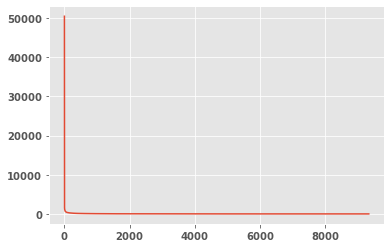

In [15]:
plt.plot(sorted(termFreqs, reverse=True))
plt.show()

#### Since we will be clustering documents, we'll need to take the transpose of this matrix so that our main data matrix is a document x term matrix. 

In [16]:
DT = df_matrix.T
DT.head()

,0,1,2,3,4,5,6,7,8,9,...,9318,9319,9320,9321,9322,9323,9324,9325,9326,9327
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
DT.shape

(2500, 9328)

#### We now have a document term matrix

In [18]:
numTerms = df_matrix.shape[0]
NDocs = df_matrix.shape[1]
print('There are %s terms.' %numTerms)
print('There are %s documents.' %NDocs)

There are 9328 terms.
There are 2500 documents.


#### Though TFxIDF weights are not necessary for clustering, we will transform the data to TFxIDF weights

In [19]:
matrix_DF = pd.DataFrame([(df_matrix != 0).sum(1)]).T
matrix_DF

,0
0,10
1,6
2,22
3,9
4,13
...,...
9323,6
9324,5
9325,3
9326,3


In [20]:
# create a matrix with all entries = NDocs
NMatrix=np.ones(np.shape(df_matrix), dtype = float) * NDocs
np.set_printoptions(precision = 2,suppress = True,linewidth = 120)
print(NMatrix)

[[2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 ...
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]]


In [21]:
# Convert each entry into IDF values
# IDF is the log of the inverse of document frequency
# Note that IDF is only a function of the term, so all columns will be identical.
IDF = np.log2(np.divide(NMatrix, np.array(matrix_DF)))

np.set_printoptions(precision=2,suppress=True)
print(IDF)

[[7.97 7.97 7.97 ... 7.97 7.97 7.97]
 [8.7  8.7  8.7  ... 8.7  8.7  8.7 ]
 [6.83 6.83 6.83 ... 6.83 6.83 6.83]
 ...
 [9.7  9.7  9.7  ... 9.7  9.7  9.7 ]
 [9.7  9.7  9.7  ... 9.7  9.7  9.7 ]
 [9.29 9.29 9.29 ... 9.29 9.29 9.29]]


In [22]:
# Finally computer the TF x IDF values for each document - term entry
TD_tfidf = df_matrix * IDF

In [23]:
pd.set_option("display.precision", 2)

TD_tfidf

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
type(TD_tfidf)

pandas.core.frame.DataFrame

<p><strong>TD_tfidf</strong> is our normalized data set ready to be split into 20% <strong>testing </strong> and 80% <strong>training </strong> data sets.</p>

#### We also need to transpose the TD_ftidf matrix 

In [25]:
TD_tfidf_tranposed = TD_tfidf.T
TD_tfidf_tranposed.shape

(2500, 9328)

#### create a 20%-80% randomized split of the data for later use.

In [26]:
# train_test_split shuffles the data and splits it into two split for us into 80% training and 20% percent testing.
vs_train, vs_test, vs_target_train, vs_target_test = train_test_split(TD_tfidf_tranposed, df_classes, test_size = 0.2, random_state = 33)

#### let's look at the shapes of the training and test data matrices.

In [27]:

vs_train.shape

(2000, 9328)

In [28]:
vs_test.shape

(500, 9328)

In [29]:
vs_target_train.shape

(2000, 1)

In [30]:
vs_target_test.shape

(500, 1)

In [31]:
vs_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9318,9319,9320,9321,9322,9323,9324,9325,9326,9327
1289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
vs_test.head()

,0,1,2,3,4,5,6,7,8,9,...,9318,9319,9320,9321,9322,9323,9324,9325,9326,9327
1590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
vs_target_train.head()

,1
0,
1289,4
596,0
1935,4
2436,4
2349,1


#### Convert the training and testing data matrices into numpy array.

In [34]:
vs_train_array = np.array(vs_train)
vs_target_train_array = vs_target_train[1].values.tolist()
vs_target_test_array = np.array(vs_target_test)

In [35]:
vs_target_train_array[:20]

[4, 0, 4, 4, 1, 2, 0, 2, 2, 4, 4, 3, 4, 2, 2, 2, 0, 3, 4, 4]

 ***
##### c. Perform Kmeans clustering on the transformed training data from part (b) [Note: if you have difficulty with TFxIDF conversion, then use the original non-transformed data for the remainder of this assignment].
 ___

In [36]:
def clusterAnalysis(centroids, clusterAssment, vs_train, df_terms):
    """This function displays the top N terms in each cluster sorted by the cluster DF values for each term, 
    the centroid weights for each term in the top N terms in the cluster (mean TFxIDF weight of the term), 
    and the size of the cluster.
    """
    doc_cluster = pd.DataFrame(clusterAssment, columns = ['Cluster','error'])
    target_labels = doc_cluster['Cluster'].unique()
    
    doc_cluster_size = {}   # declare an empty dictionary of cluster sizes
    booleanFlag = None       # flag for subselection
    termsDF = pd.DataFrame(df_terms[0].values.tolist(), columns = ['term'])
    for c in target_labels:
        # assign term index to each of the clusters.
        cluster_index_TrainData = vs_train.index[doc_cluster['Cluster'] == int(c)]

        centroidsWeights = pd.DataFrame(centroids[int(c)], columns =['Weights'])
        # determine the cluster size
        clusterSize = len(vs_train.index[doc_cluster['Cluster'] == int(c)])

        # populate a dictionary of cluster sizes.
        doc_cluster_size[int(c)] = clusterSize

        #Check whether the training data (tfidx document * term ) set's index are in the cluster_index_TrainData
        booleanFlag = vs_train.index.isin(cluster_index_TrainData)

        clusterDocs = vs_train[booleanFlag]

        # let's find the document counts for each term by transposing clusterDocs to get term by document and counting all the non zero terms
        clusterDocsT = clusterDocs.T

        DocTermFreq = pd.DataFrame([(clusterDocsT != 0).sum(1)]).T
        DocTermFreq.columns = ['DF']
        DocTermFreq['% of Ndocs'] = DocTermFreq['DF'] / doc_cluster_size[int(c)] * 100

        # lets merge the terms, centroid and DocTermFreqPercentage
        print('Cluster %s\n\n\nCluster size: %s\n\n Top 5 terms in Cluster %s \n\n' %(int(c), doc_cluster_size[int(c)], int(c)))
        clusterTermCentroid = pd.concat([termsDF, centroidsWeights ,DocTermFreq], axis = 1)
        # Sort the data frame by % of Ndocs in descending order
        sortedClTerm = clusterTermCentroid.sort_values(['DF', 'Weights'], ascending = False)
        
        # Select the Top 5 records from the sorted Data Frame
        top5Rows = sortedClTerm[['term', 'DF', '% of Ndocs']].head()   
        emptyIndex = [''] * len(top5Rows)
        top5Rows.index = emptyIndex
        print('%s \n' %top5Rows)
        print('*'*40)

</p>We shall use the above function,<strong>clusterAnalysis</strong>, to display the <strong>top 5 terms </strong> in each cluster sorted by the cluster DF values for each term, the centroid weights for each term in the top N terms in the cluster (mean TFxIDF weight of the term), and the size of the cluster</p>

In [37]:
%time
print('Running Kmeans when k = 4')
centroids4, clusterAssment4 = kMeans(vs_train_array, 4, cosineDist, randCent)

Wall time: 0 ns
Running Kmeans when k = 4


In [38]:
clusterAnalysis(centroids4, clusterAssment4, vs_train, df_terms)

Cluster 0


Cluster size: 1596

 Top 5 terms in Cluster 0 


    term   DF  % of Ndocs
   write  716       44.86
      on  556       34.84
  articl  535       33.52
     get  483       30.26
    know  420       26.32 

****************************************
Cluster 3


Cluster size: 356

 Top 5 terms in Cluster 3 


       term   DF  % of Ndocs
      write  215       60.39
         on  196       55.06
        god  186       52.25
     articl  171       48.03
  christian  170       47.75 

****************************************
Cluster 2


Cluster size: 40

 Top 5 terms in Cluster 2 


    term  DF  % of Ndocs
     sin  31        77.5
   write  29        72.5
     god  28        70.0
      on  22        55.0
  origin  19        47.5 

****************************************
Cluster 1


Cluster size: 8

 Top 5 terms in Cluster 1 


 term  DF  % of Ndocs
   ax   7        87.5
  max   7        87.5
   pl   6        75.0
  giz   6        75.0
  bxn   6        75.0 

*******************

In [39]:
%time
print('Running Kmeans when k = 5')
centroids5, clusterAssment5 = kMeans(vs_train_array, 5, cosineDist, randCent)

Wall time: 0 ns
Running Kmeans when k = 5


In [40]:
sortedClTerm = clusterAnalysis(centroids5, clusterAssment5, vs_train, df_terms)

Cluster 4


Cluster size: 374

 Top 5 terms in Cluster 4 


   term   DF  % of Ndocs
   sale  222       59.36
  email  145       38.77
  pleas  122       32.62
  offer  105       28.07
   ship   98       26.20 

****************************************
Cluster 1


Cluster size: 847

 Top 5 terms in Cluster 1 


    term   DF  % of Ndocs
   write  518       61.16
  articl  394       46.52
      on  356       42.03
     get  295       34.83
      go  283       33.41 

****************************************
Cluster 3


Cluster size: 402

 Top 5 terms in Cluster 3 


    term   DF  % of Ndocs
  window  277       68.91
   write  179       44.53
    file  143       35.57
      do  138       34.33
     get  137       34.08 

****************************************
Cluster 2


Cluster size: 369

 Top 5 terms in Cluster 2 


       term   DF  % of Ndocs
      write  230       62.33
        god  211       57.18
         on  203       55.01
     articl  178       48.24
  christian  173       4

<p><strong>k = 5 </strong> gives us well defined clusters and we have the cluster sizes defined below:<ul><li>Size of Cluster 0 = 7</li><li>Size of Cluster 1 = 402</li><li>Size of Cluster 2 = 773</li><li>Size of Cluster 3 = 790</li><li>Size of Cluster 4 = 28</li></ul></p>
<p>The difference of cluster sizes between Cluster 2 and 3 is not big, however looking at Cluster 0 and 4 are very small, which could either mean noise or outliers. Also, we could combine Cluster 0, and 4 and do further research to determine if it has any impact on the segmentation.</p>
<p>In Cluster 3, we have terms like write, which appear in almost every other cluster. The article term, which appears in the Cluster 3, also appears in Clusters 1 and 4. </p>
<p>Overall, <strong>k = 5</strong> produces well defined clusters.</p>

##### [Extra Credit - 5pt: use your favorite third party tool, ideally with a Python based API, to create a word cloud for each cluster.]

In [41]:
def clusterAnalysis_with_weights(centroids, clusterAssment, k, vs_train, df_terms):
    
    doc_cluster = pd.DataFrame(clusterAssment, columns = ['Cluster','error'])
    
    target_labels = doc_cluster['Cluster'].unique()

    doc_cluster_size = {}   # declare an empty dictionary of cluster sizes
    
    booleanFlag = None       # flag for subselection
    
    termsDF = pd.DataFrame(df_terms[0].values.tolist(), columns = ['term'])
    
    for c in target_labels:
        # assign term index to each of the clusters.
        cluster_index_TrainData = vs_train.index[doc_cluster['Cluster'] == int(c)]


        centroidsWeights = pd.DataFrame(centroids[int(c)], columns =['Weights'])

        # determine the cluster size
        clusterSize = len(vs_train.index[doc_cluster['Cluster'] == int(c)])

        # populate a dictionary of cluster sizes.
        doc_cluster_size[int(c)] = clusterSize

        #Check whether the training data (tfidx document * term ) set's index are in the cluster_index_TrainData
        booleanFlag = vs_train.index.isin(cluster_index_TrainData)

        clusterDocs = vs_train[booleanFlag]

        # let's find the document counts for each term by transposing clusterDocs to get term by document and counting all the non zero terms

        clusterDocsT = clusterDocs.T

        DocTermFreq = pd.DataFrame([(clusterDocsT != 0).sum(1)]).T

        DocTermFreq.columns = ['DF']

        DocTermFreq['% of Ndocs'] = DocTermFreq['DF'] / doc_cluster_size[int(c)] * 100

        # lets merge the terms, centroid and DocTermFreqPercentage
#         print('Cluster %s\n\n\nCluster size: %s\n\n Top 5 terms in Cluster %s \n\n' %(int(c), doc_cluster_size[int(c)], int(c)))
        clusterTermCentroid = pd.concat([termsDF, centroidsWeights ,DocTermFreq], axis = 1)

        # Sort the data frame by % of Ndocs in descending order
        sortedClTerm = clusterTermCentroid.sort_values(['DF', 'Weights'], ascending = False)

        # Derive the data set for the word Cloud based on the weights.
        weights = pd.Series(sortedClTerm['Weights'].round(decimals = 2).values.tolist())
        weights.index = sortedClTerm['term']
        dict_weights = weights.to_dict() # Convert the Series into dictionary
        cloud = WordCloud(width=900, height=700, background_color = 'white' ).generate_from_frequencies(dict_weights)
        print('Word cloud based on all terms within Cluster %s when k = %s \n' %(str(int(c)), k))

        # reset the index
        emptyIndex = [''] * sortedClTerm.shape[0]
        sortedClTerm.index = emptyIndex
        print(sortedClTerm)

        plt.imshow(cloud, interpolation = 'bilinear')
        plt.axis('off')
        plt.show()

Word cloud based on all terms within Cluster 4 when k = 5 

     term  Weights   DF  % of Ndocs
     sale     2.79  222       59.36
    email     1.13  145       38.77
    pleas     0.96  122       32.62
    offer     1.53  105       28.07
     ship     1.63   98       26.20
..    ...      ...  ...         ...
    zubov     0.00    0        0.00
       zv     0.00    0        0.00
       zw     0.00    0        0.00
       zx     0.00    0        0.00
       zz     0.00    0        0.00

[9328 rows x 4 columns]


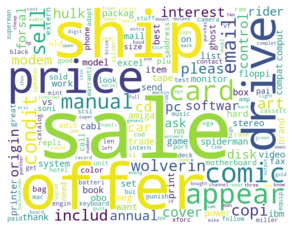

Word cloud based on all terms within Cluster 1 when k = 5 

      term  Weights   DF  % of Ndocs
     write     0.85  518       61.16
    articl     0.88  394       46.52
        on     1.07  356       42.03
       get     1.20  295       34.83
        go     1.30  283       33.41
..     ...      ...  ...         ...
        zu     0.00    0        0.00
        zv     0.00    0        0.00
        zw     0.00    0        0.00
        zx     0.00    0        0.00
        zz     0.00    0        0.00

[9328 rows x 4 columns]


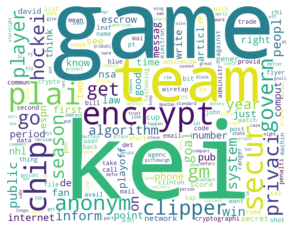

Word cloud based on all terms within Cluster 3 when k = 5 

      term  Weights   DF  % of Ndocs
    window     5.71  277       68.91
     write     0.65  179       44.53
      file     4.13  143       35.57
        do     3.33  138       34.33
       get     0.93  137       34.08
..     ...      ...  ...         ...
     zubov     0.00    0        0.00
        zv     0.00    0        0.00
        zw     0.00    0        0.00
        zx     0.00    0        0.00
        zz     0.00    0        0.00

[9328 rows x 4 columns]


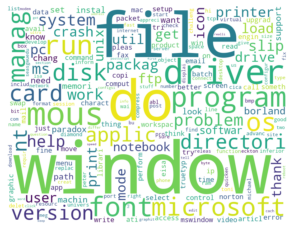

Word cloud based on all terms within Cluster 2 when k = 5 

         term  Weights   DF  % of Ndocs
        write     0.90  230       62.33
          god     7.71  211       57.18
           on     2.04  203       55.01
       articl     0.93  178       48.24
    christian     5.26  173       46.88
..        ...      ...  ...         ...
       zipper     0.00    0        0.00
          zkn     0.00    0        0.00
        zombo     0.00    0        0.00
         zoom     0.00    0        0.00
        zubov     0.00    0        0.00

[9328 rows x 4 columns]


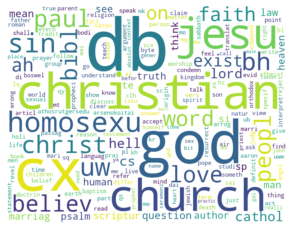

Word cloud based on all terms within Cluster 0 when k = 5 

     term   Weights  DF  % of Ndocs
       ax  41973.81   7        87.5
      max   2877.51   7        87.5
       pl    315.20   6        75.0
      giz    185.44   6        75.0
      bxn    136.75   6        75.0
..    ...       ...  ..         ...
       zu      0.00   0         0.0
    zubov      0.00   0         0.0
       zv      0.00   0         0.0
       zx      0.00   0         0.0
       zz      0.00   0         0.0

[9328 rows x 4 columns]


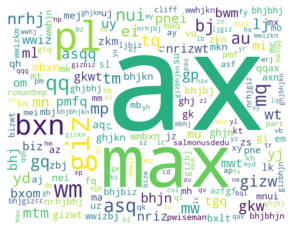

In [42]:
clusterAnalysis_with_weights(centroids5, clusterAssment5, 5, vs_train, df_terms)

We learn that:
<ul>
<li>In <strong>Cluster 4</strong> when k = 5, the term Window appears more frequently. Terms like sale, file, do driver stand out from other terms. Terms like sell, number are not mentioned as much and that is why they appear small in size.</li>
<li>In <strong>Cluster 0</strong>, terms like encrypt, Kei, Chip, govern really stand out because they are mentioned in most documents. Also, cluster 0 has some stop words, which I could have removed.</li>
<li>In <strong>Cluster 3</strong>, terms like think, on, Christian, church, god, team really stand because they are also mentioned in most documents.</li>
<li>In <strong>Cluster 2</strong>, terms like bo, chi, and tor stand out because they are mentioned in most documents. The term bit is very tiny, which means that it is only mentioned in a few documents.</li>
<li>In <strong>Cluster 1</strong>, the terms max, ax, giz, and pl stand out since they are the most mentioned terms in that cluster. </li>
</ul>

#### d. Using the cluster assignments from your Kmeans clustering and the original cluster labels for the training document, compare your clusters to the re-assigned classes by computing the Completeness and Homogeneity values. You should do this for the best values of k and the best clustering run you settled on in the previous part. 

In [43]:
docCluster5 = pd.DataFrame(clusterAssment5, columns = ['Cluster','error']) 

In [44]:
newC5 = docCluster5['Cluster'].astype(int)

In [45]:
newC5.head()

0    4
1    1
2    4
3    4
4    1
Name: Cluster, dtype: int32

In [46]:
print(completeness_score(vs_target_train_array,newC5))

0.8109802445537673


In [47]:
print(homogeneity_score(vs_target_train_array,newC5))

0.6721733006805563


<p>The completeness score approaches 1 when most of the data points that are members of a given class are elements of the same cluster while the homogeneity score  approaches 1 when all the clusters contain almost only data points that members of a single class.</p>

##### [Extra Credit - 5 pts: You can try other clustering runs with values of k between 4 and 8 and in each case compute Completeness and Homogeneity. This experiment will indicate which clustering provides the best representation of the original newsgroup categories.]

In [48]:
%time
# (dataSet, k, distMeas=distEuclid, createCent=randCent)
print('Running Kmeans when k = 6')
centroids6, clusterAssment6 = kMeans(vs_train_array, 6, cosineDist, randCent)

Wall time: 0 ns
Running Kmeans when k = 6


In [49]:
clusterAnalysis(centroids6, clusterAssment6, vs_train, df_terms)

Cluster 3


Cluster size: 359

 Top 5 terms in Cluster 3 


   term   DF  % of Ndocs
   sale  219       61.00
  email  136       37.88
  pleas  113       31.48
  offer  105       29.25
   ship   97       27.02 

****************************************
Cluster 4


Cluster size: 331

 Top 5 terms in Cluster 4 


    term   DF  % of Ndocs
  window  221       66.77
   write  154       46.53
     get  124       37.46
      do  123       37.16
     run  113       34.14 

****************************************
Cluster 1


Cluster size: 1173

 Top 5 terms in Cluster 1 


    term   DF  % of Ndocs
   write  728       62.06
  articl  560       47.74
      on  543       46.29
    know  405       34.53
   think  400       34.10 

****************************************
Cluster 0


Cluster size: 123

 Top 5 terms in Cluster 0 


     term  DF  % of Ndocs
     file  78       63.41
   window  59       47.97
    write  50       40.65
  program  47       38.21
    thank  44       35.77 

**********

In [50]:
%time
# (dataSet, k, distMeas=distEuclid, createCent=randCent)
print('Running Kmeans when k = 7')
centroids7, clusterAssment7 = kMeans(vs_train_array, 7, cosineDist, randCent)

Wall time: 0 ns
Running Kmeans when k = 7


In [51]:
clusterAnalysis(centroids7, clusterAssment7, vs_train, df_terms)

Cluster 6


Cluster size: 39

 Top 5 terms in Cluster 6 


    term  DF  % of Ndocs
      cd  20       51.28
  forsal  16       41.03
     ask  16       41.03
   pleas  16       41.03
    sale  15       38.46 

****************************************
Cluster 1


Cluster size: 401

 Top 5 terms in Cluster 1 


    term   DF  % of Ndocs
   write  223       55.61
    game  212       52.87
    team  195       48.63
      go  178       44.39
  articl  173       43.14 

****************************************
Cluster 5


Cluster size: 376

 Top 5 terms in Cluster 5 


   term   DF  % of Ndocs
   sale  211       56.12
  email  134       35.64
  pleas  121       32.18
  offer  104       27.66
  thank   99       26.33 

****************************************
Cluster 2


Cluster size: 738

 Top 5 terms in Cluster 2 


    term   DF  % of Ndocs
   write  410       55.56
      on  307       41.60
  articl  297       40.24
     get  266       36.04
    know  249       33.74 

******************

In [52]:
%time
# (dataSet, k, distMeas=distEuclid, createCent=randCent)
print('Running Kmeans when k = 8')
centroids8, clusterAssment8 = kMeans(vs_train_array, 8, cosineDist, randCent)

Wall time: 0 ns
Running Kmeans when k = 8


In [53]:
clusterAnalysis(centroids8, clusterAssment8, vs_train, df_terms)

Cluster 1


Cluster size: 26

 Top 5 terms in Cluster 1 


    term  DF  % of Ndocs
   pleas  12       46.15
   email  12       46.15
     jai  11       42.31
      cd  10       38.46
  forsal  10       38.46 

****************************************
Cluster 5


Cluster size: 405

 Top 5 terms in Cluster 5 


    term   DF  % of Ndocs
   write  221       54.57
    game  213       52.59
    team  195       48.15
      go  177       43.70
  articl  172       42.47 

****************************************
Cluster 3


Cluster size: 358

 Top 5 terms in Cluster 3 


   term   DF  % of Ndocs
   sale  212       59.22
  email  137       38.27
  pleas  106       29.61
  offer  104       29.05
   ship   92       25.70 

****************************************
Cluster 6


Cluster size: 396

 Top 5 terms in Cluster 6 


     term   DF  % of Ndocs
    write  267       67.42
   articl  204       51.52
      kei  185       46.72
  clipper  185       46.72
  encrypt  183       46.21 

************

In [54]:
docCluster4 = pd.DataFrame(clusterAssment4, columns = ['Cluster','error']) 

In [55]:
docCluster6 = pd.DataFrame(clusterAssment6, columns = ['Cluster','error']) 

In [56]:
docCluster7 = pd.DataFrame(clusterAssment7, columns = ['Cluster','error']) 

In [57]:
docCluster8 = pd.DataFrame(clusterAssment8, columns = ['Cluster','error']) 

In [58]:
newC4 = docCluster4['Cluster'].astype(int)
newC4.head()

0    0
1    0
2    0
3    0
4    0
Name: Cluster, dtype: int32

In [59]:
newC6 = docCluster6['Cluster'].astype(int)
newC6.head()

0    3
1    4
2    3
3    3
4    1
Name: Cluster, dtype: int32

In [60]:
newC6 = docCluster6['Cluster'].astype(int)

In [61]:
newC7 = docCluster7['Cluster'].astype(int)
newC7.head()

0    6
1    1
2    6
3    5
4    2
Name: Cluster, dtype: int32

In [62]:
newC8 = docCluster8['Cluster'].astype(int)
newC8.head()

0    1
1    5
2    1
3    3
4    6
Name: Cluster, dtype: int32

In [63]:
print(completeness_score(vs_target_train_array,newC4))

0.7345504040109242


In [64]:
print(homogeneity_score(vs_target_train_array,newC4))

0.2682203994249907


<p>Cluster 4 has good completness score of 0.7, which approaches 1 but with a poor homegeneity score of 0.3 which is very low.</p>

In [65]:
print(completeness_score(vs_target_train_array,newC6))

0.6539487102766182


In [66]:
print(homogeneity_score(vs_target_train_array,newC6))

0.45918500930951356


<p>The completeness score approaches 1 when most of the data points that are members of a given class are elements of the same cluster while the homogeneity score tries to approaches 1 when all the clusters contain almost only data points that are member of a single class, but the score is low.</p>

In [67]:
print(completeness_score(vs_target_train_array,newC7))

0.6894201837390005


In [68]:
print(homogeneity_score(vs_target_train_array,newC7))

0.6579974433658079


<p>Also k = 7 seems to have good clusters since its hmogeneity and completeness's scores approach 1.</p>

In [69]:
print(completeness_score(vs_target_train_array,newC8))

0.8139165682609174


In [70]:
print(homogeneity_score(vs_target_train_array,newC8))

0.8486255012340258


<p>Also k = 8 seems to have good clusters since its homogeneity and completeness's scores approach 1.</p>

In [71]:
from sklearn import metrics

In [89]:
def plot_silhouettes(data, clusters, metric='cosine'):
    
    from matplotlib import cm
    from sklearn.metrics import silhouette_samples

    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = metrics.silhouette_samples(data, clusters, metric='cosine')
    c_ax_lower, c_ax_upper = 0, 0
    cticks = []
    for i, k in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[clusters == k]
        c_silhouette_vals.sort()
        c_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        pl.barh(range(c_ax_lower, c_ax_upper), c_silhouette_vals, height=1.0, 
                      edgecolor='none', color=color)

        cticks.append((c_ax_lower + c_ax_upper) / 2)
        c_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    pl.axvline(silhouette_avg, color="red", linestyle="--") 
    pl.yticks(cticks, cluster_labels)
    pl.ylabel('Cluster')
    pl.xlabel('Silhouette coefficient')

    pl.tight_layout()
    #pl.savefig('images/11_04.png', dpi=300)
    pl.show()
    
    return

Silhouette plot when k = 6


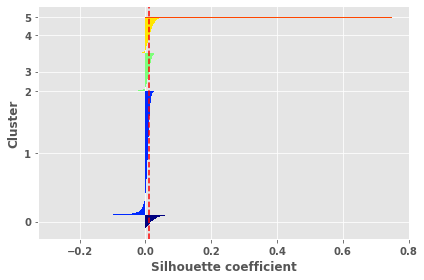

In [90]:
print('Silhouette plot when k = 6')
plot_silhouettes(vs_train_array, newC6)

<p>The plot above shows that with the exception of cluster 5, all clusters are not scoring so well for the silhoutes because they have a bunch of scores below the average.</p>
<p>The silhouette coefficient for cluster 5 stands outs as it is seen approaching 1.</p>

Silhouette plot when k = 7


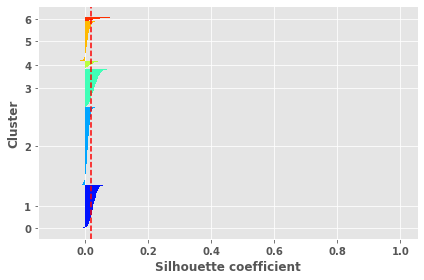

In [91]:
print('Silhouette plot when k = 7')
plot_silhouettes(vs_train_array, newC7)

<p>All of clusters are not scoring so well for silhoutes because they have a bunch of scores below the average.</p>

Silhouette plot when k = 8


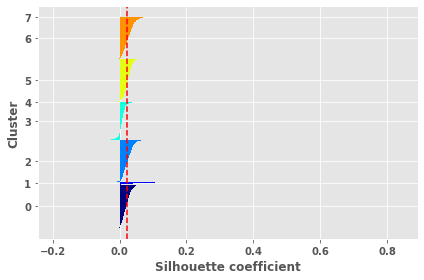

In [93]:
print('Silhouette plot when k = 8')
plot_silhouettes(vs_train_array, newC8)

<p>The above same plot shows that the rest of the clusters are not scoring so well for silhoutes because they have a bunch of scores below the average.</p>
<p>K = 8 seems to have good clusters but the silhouette coefficients for most of the clusters is below average with both its completeness and homogeneity approaching 1. </p>
<p>So, k = 8 provides the best representation of the original newsgroup categories. </p>

 ***
##### e. Finally, using your cluster assignments as class labels, categorize each of the documents in the 20% set-aside data into each of the appropriate cluster. Your categorization should be based on Cosine similarity between each test document and cluster centroids. For each test document show the predicted class label as well as Cosine similarity to the corresponding cluster. 
___

##### for each test instance calculate the cosine similarity to each centroid when K  = 5

In [94]:
def clusterPrediction(dataSet, k, distMeas, centroids):
    """
    Function that returns Cluster assigments for the unseen data (test data)
    """
    m = shape(dataSet)[0]
    clusterAssment = zeros((m,2)) #create mat to assign data points 
                                  #to a centroid, also holds SE of each point
#     centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m): #for each data point assign it to the closest centroid
            minDist = inf; minIndex = -1
            for j in range(k):  #find the closest distance
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        # print centroids
        for cent in range(k):#recalculate centroids and update the centroid location
            ptsInClust = dataSet[nonzero(clusterAssment[:,0]==cent)[0]] #get all the point in this cluster - Note: this was incorrect in the original distribution.
            if(len(ptsInClust)!=0):
                centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean - Note condition was added 10/28/2013
    return clusterAssment  

In [95]:
# convert the test tfXidf test matrix data into numpy a array
vs_test_array = np.array(vs_test)

In [96]:
# using the clusterPrediction function, lets predict the class label as well as the cosine Similarity of the testing data sets.
clusterAssment  = clusterPrediction(vs_test_array, 5, cosineDist, centroids5)

In [97]:
##### Convert the predicted cluster assignments numpy array into data frame
df_predictedLabel = pd.DataFrame(clusterAssment, columns = ['Class_Label', 'Cosine_Similarity'])
df_predictedLabel['Class_Label'] = df_predictedLabel['Class_Label'].astype(int)
df_predictedLabel.head(20)

,Class_Label,Cosine_Similarity
0,2,0.81
1,2,0.61
2,4,0.83
3,3,0.60
4,4,0.62
5,1,0.46
6,1,0.60
7,1,0.83
8,2,0.37
9,2,0.82


<p>Above, we have data frame,<strong>df_predictedLabel</strong>, that has the predicted class labels as well as the Cosine similarity to the corresponding clusters.</p>